# Predicción de la progresión de la enfermedad de Parkinson

## Contexto

La enfermedad de Parkinson (EP) es un trastorno cerebral incapacitante que afecta los movimientos, la cognición, el sueño y otras funciones normales. Desafortunadamente, no existe una cura actual y la enfermedad empeora con el tiempo. Se estima que para 2037, 1.6 millones de personas en los EE.UU.
tendrán la enfermedad de Parkinson, con un costo económico cercano a los $80 mil millones. Las investigaciones indican que las anomalías de proteínas o péptidos desempeñan un papel clave en la aparición y el empeoramiento de esta enfermedad. Obtener una mejor comprensión de esto, con la ayuda de la ciencia de datos, podría proporcionar pistas importantes para el desarrollo de nuevas farmacoterapias para retrasar la progresión o curar la enfermedad de Parkinson.

Los esfuerzos actuales han dado como resultado datos clínicos y neurobiológicos complejos sobre más de 10 000 sujetos para un amplio intercambio con la comunidad investigadora. Se han publicado varios hallazgos importantes utilizando estos datos, pero aún faltan biomarcadores claros o curas.

Los datos utilizados en este Proyecto fueron brindados por Accelerating Medicines Partnership® Parkinson's Disease (AMP®PD) las cual es una asociación público-privada entre el gobierno, la industria y organizaciones sin fines de lucro administrada a través de la Fundación de los Institutos Nacionales de Salud (FNIH). La Asociación creó la Plataforma de conocimiento de AMP PD, que incluye una caracterización molecular profunda y un perfil clínico longitudinal de pacientes con enfermedad de Parkinson, con el objetivo de identificar y validar biomarcadores de diagnóstico, pronóstico y/o progresión de la enfermedad para la enfermedad de Parkinson.

En México, no existen cifras exactas de pacientes de Parkinson. Sin embargo, el Instituto Nacional de Neurología y Neurocirugía estima una prevalencia de 50 casos nuevos por cada 100 mil habitantes al año. A nivel mundial, se calcula que cuatro o cinco millones de personas mayores de 50 años puedan padecer esta enfermedad.

In [ ]:
## librerías utilizadas

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from scipy import stats
from tqdm import tqdm
!pip install pingouin
import pingouin as pg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from keras import layers
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=c6250dd485285fe030377195a78b8ee1bb32553b61192916b9ae867e29ed5e63
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


## Carga del Dataset, limpieza de datos y análisis exploratorio de los datos.

In [ ]:
data_proteins = pd.read_csv("/content/drive/MyDrive/Data_Parkinson/train_proteins.csv")
data_peptides = pd.read_csv("/content/drive/MyDrive/Data_Parkinson/train_peptides.csv")
data_clinical = pd.read_csv("/content/drive/MyDrive/Data_Parkinson/train_clinical_data.csv")

Vamos a examinar estos DataFrames en detalle. Empezemos por `data_clinical`.

**Nota:**

**UPDRS** es un instrumento de calificación utilizado para medir la gravedad y la progresión de la enfermedad de Parkinson en los pacientes. Cuando un paciente visita la clínica, la clínica registrará la puntuación del paciente en 4 partes de la prueba UPDRS. Estos datos se pueden encontrar en `train_clinical`. Las calificaciones para los primeros 4 segmentos de UPDRS están disponibles como `updrs_1`, `updrs_2`, `updrs_3` y `updrs_4` en `train_clinical`. *Nuestro objetivo es entrenar un modelo para predecir estas calificaciones UPDRS.*

Las variables guardadas en el DataFrame son:

* `visit_id`: ID de la visita del paciente.
* `visit_month`: El mes de la visita, relativo a la primera visita del paciente.
* `patient_id`: ID del paciente.
* `updrs_[1-4]`: La puntuación del paciente para la parte N de la [Escala unificada de calificación de la enfermedad de Parkinson](https://www.movementdisorders.org/MDS/MDS-Rating-Scales/MDS-Unified-Parkinsons-Disease-Rating-Scale-MDS-UPDRS.htm). Los números más altos indican síntomas más graves. Cada subsección cubre una categoría distinta de síntomas, como el estado de ánimo y el comportamiento para la Parte 1 y las funciones motoras para la Parte 3.

* `upd23b_clinical_state_on_medication`: Si el paciente estaba tomando o no medicamentos como Levodopa durante la evaluación UPDRS. Se espera que afecte principalmente las puntuaciones de la Parte 3 (función motora). Estos medicamentos desaparecen con bastante rapidez (del orden de un día), por lo que es común que los pacientes se hagan el examen de función motora dos veces en un solo mes, con y sin medicación.

In [ ]:
data_clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [ ]:
data_clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2590 non-null   float64
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 163.6+ KB


In [ ]:
print(data_clinical.shape)
initial_obs = data_clinical.shape[0]

(2615, 8)


In [ ]:
num_patient = len(data_clinical['patient_id'].unique())

print(f'En la tabla se tiene información de {num_patient} pacientes.')

En la tabla se tiene información de 248 pacientes.


En `data_clinical` nosotros encontramos **8 columnas** y **2615 entradas**. Además, observamos que existen valores perdidos en la variable `updrs_4` y en la variable `upd23b_clinical_state_on_medication`.

In [ ]:
(data_clinical.isna().sum()/data_clinical.shape[0])*100

visit_id                                0.000000
patient_id                              0.000000
visit_month                             0.000000
updrs_1                                 0.038241
updrs_2                                 0.076482
updrs_3                                 0.956023
updrs_4                                39.694073
upd23b_clinical_state_on_medication    50.745698
dtype: float64

**Nota:**

En efecto, encontramos valores perdidos en todas las variables que se miden. Los casos más problemáticos son las variables `updrs_4` y `upd23b_clinical_state_on_medication` que tienen un **40%** y **51%** de datos perdidos respectivamente.

In [ ]:
both_miss = data_clinical[(data_clinical['updrs_4'].isna()) & (data_clinical['upd23b_clinical_state_on_medication'].isna())].shape[0]
updrs_4_miss = data_clinical['updrs_4'].isna().sum()
upd23b_miss = data_clinical['upd23b_clinical_state_on_medication'].isna().sum()

print('Cantidad de observaciones con valores perdidos en ambas variables:', both_miss)
print('Cantidad de observaciones con valores perdidos en updrs_4:', updrs_4_miss)
print('Cantidad de observaciones con valores perdidos en upd23b_clinical_state_on_medication:', upd23b_miss)

Cantidad de observaciones con valores perdidos en ambas variables: 1016
Cantidad de observaciones con valores perdidos en updrs_4: 1038
Cantidad de observaciones con valores perdidos en upd23b_clinical_state_on_medication: 1327


**Nota:**

La mayoría de las observaciones con valores perdidos en alguna de las dos variables, lo tienen en ambas, lo que puede significar que los hechos de que haya valores perdidos en alguna de las variables están correlacionado.

In [ ]:
c = ~(data_clinical['upd23b_clinical_state_on_medication'].isna())
data_clinical['upd23b_clinical_state_on_medication'] = data_clinical['upd23b_clinical_state_on_medication'].where(c, 'N/A')

In [ ]:
data_clinical['upd23b_clinical_state_on_medication'].value_counts(normalize = True)*100

N/A    50.745698
On     29.636711
Off    19.617591
Name: upd23b_clinical_state_on_medication, dtype: float64

In [ ]:
data_clinical = data_clinical.dropna(subset = ['updrs_1', 'updrs_2', 'updrs_3']).reset_index(drop = True)

In [ ]:
drop_obs = data_clinical.shape[0]
per_drop = (initial_obs - drop_obs)/initial_obs*100
print(f'El porcentaje de observaciones eliminadas fue {per_drop}.')

El porcentaje de observaciones eliminadas fue 1.0325047801147227.


In [ ]:
data_clinical.groupby('upd23b_clinical_state_on_medication')['updrs_3'].describe()

,count,mean,std,min,25%,50%,75%,max
upd23b_clinical_state_on_medication,,,,,,,,
N/A,1308.0,12.036697,12.862710,0.0,1.0,7.0,21.0,68.0
Off,513.0,30.871345,12.229216,1.0,22.0,30.0,38.0,78.0
On,767.0,24.368970,13.122469,1.0,15.0,22.0,31.0,86.0


**Nota:**

Note que los pacientes medicados tienen menor media y mediana que los pacientes medicados. Sin embargo, de los tres grupos aquellos pacientes que no tienen información sobre si están medicados o no, tienen menores valores de la variable `updrs_3` mucho menores. En mi opinión, esto podría indicar que estos últimos pacientes están en un estadío inicial de la enfermedad donde no se medican todavía, por lo que no aplica la pregunta de si se medican o no. Probablemente, en estos pacientes tampoco se pueda medir el indicador `updrs_4`, de ahí que estos también estén faltando.

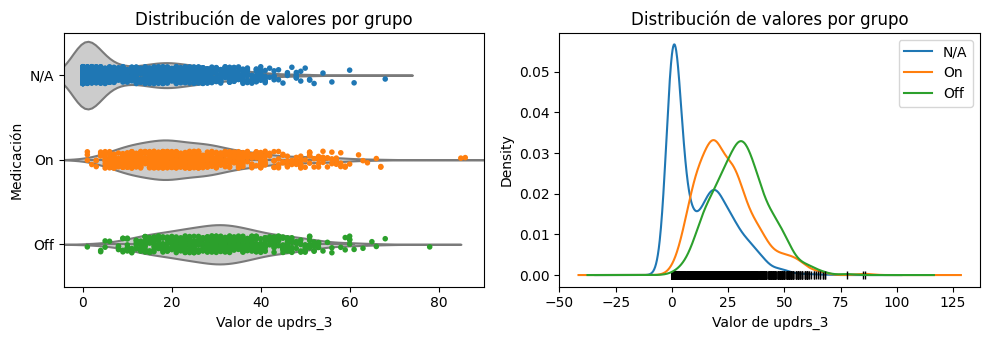

In [ ]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
sns.violinplot(
    x     = data_clinical.updrs_3,
    y     = data_clinical.upd23b_clinical_state_on_medication,
    color = ".8",
    ax    = axs[0]
)
sns.stripplot(
    x    = data_clinical.updrs_3,
    y    = data_clinical.upd23b_clinical_state_on_medication,
    data = data_clinical,
    size = 4,
    jitter  = 0.1,
    palette = 'tab10',
    ax = axs[0]
)
axs[0].set_title('Distribución de valores por grupo')
axs[0].set_ylabel('Medicación')
axs[0].set_xlabel('Valor de updrs_3');

for medication in data_clinical.upd23b_clinical_state_on_medication.unique():
    datos_temp = data_clinical[data_clinical.upd23b_clinical_state_on_medication == medication]['updrs_3']
    datos_temp.plot.kde(ax=axs[1], label=medication)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

axs[1].set_title('Distribución de valores por grupo')
axs[1].set_xlabel('Valor de updrs_3');
axs[1].legend()

fig.tight_layout();

## Prueba de comparación de medias (Bootstraping)
### Grupos N/A y On

In [ ]:
dif_observada = data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'On'].updrs_3.mean()
- data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'N/A'].updrs_3.mean()

print(f'El valor de la diferencia de medias observada: {dif_observada}')

El valor de la diferencia de medias observada: 24.36897001303781


In [ ]:
def bootstraping_2_grupos(x1, x2, n_iteraciones=9999):
    '''
    Función para calcular la diferencia de un estadístico entre dos grupos en
    múltiples muestras generadas mediante muestreo repetido con reposición
    (bootstrapping).

    Parameters
    ----------
    x1 : numpy array
         valores de la muestra del grupo 1.

    x2 : numpy array
         valores de la muestra del grupo 2.

    n_iteraciones : int
        número iteraciones (default `9999`).

    Returns
    -------
    distribuciones: numpy array
        diferencia entre ambos grupos en cada muestra de bootstrapping.
    '''

    n1 = len(x1)
    n2 = len(x2)
    pool = np.hstack((x1, x2))
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)

    for i in tqdm(range(n_iteraciones)):
        # Se crea una nueva muestra
        resample = np.random.choice(pool, size=n1+n2, replace=True)
        # Se reparten las observaciones en dos grupos y se calcula el estadístico
        estadistico_1 = np.mean(resample[:n1])
        estadistico_2 = np.mean(resample[n1:])
        # Diferencia entre estadísticos
        dist_boot[i]  = estadistico_1 - estadistico_2

    return dist_boot

In [ ]:
dist_boot = bootstraping_2_grupos(
                x1 = data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'N/A'].updrs_3,
                x2 = data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'On'].updrs_3,
                n_iteraciones = 9999
            )

100%|██████████| 9999/9999 [00:03<00:00, 2914.54it/s]


**Nota:**

Hemos obtenido lo que se llama la *distribución de bootstrapping* de la diferencia de medias.

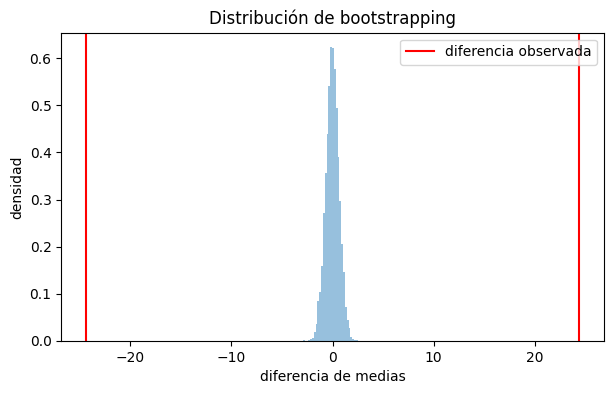

In [ ]:
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=-dif_observada, color='red')

ax.set_title('Distribución de bootstrapping')
ax.set_xlabel('diferencia de medias')
ax.set_ylabel('densidad')
ax.legend();

In [ ]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_boot) > dif_observada))/len(dist_boot)
p_value_correc = (sum(np.abs(dist_boot) > dif_observada) + 1)/len(dist_boot + 1)
print(f"p-value sin corrección: {p_value}")
print(f"p-value con corrección: {p_value_correc}")

p-value sin corrección: 0.0
p-value con corrección: 0.00010001000100010001


**Nota:**

Según el p-valor obtenido, mucho menor que el umbral 0.05, podemos decir que existe evidencia estadística para asegurar que existen diferencias sustanciales entre las medias de ambos grupos.

### Grupos N/A y Off

In [ ]:
dif_observada = abs(data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'N/A'].updrs_3.mean()
                 - data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'Off'].updrs_3.mean())

print(f'El valor de la diferencia de medias observada: {dif_observada}')

El valor de la diferencia de medias observada: 18.83464778153334


In [ ]:
dist_boot = bootstraping_2_grupos(
                x1 = data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'N/A'].updrs_3,
                x2 = data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'Off'].updrs_3,
                n_iteraciones = 9999
            )

100%|██████████| 9999/9999 [00:03<00:00, 2920.09it/s]


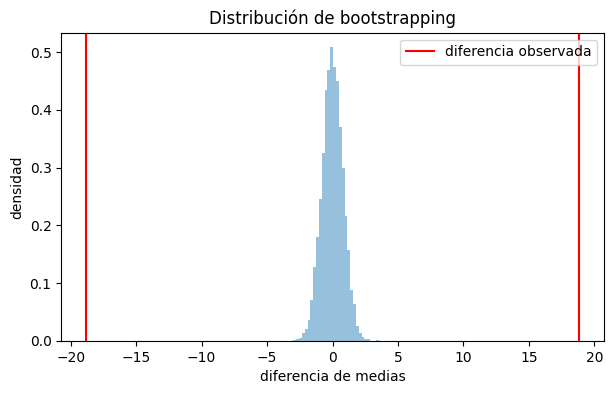

In [ ]:
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=-dif_observada, color='red')

ax.set_title('Distribución de bootstrapping')
ax.set_xlabel('diferencia de medias')
ax.set_ylabel('densidad')
ax.legend();

In [ ]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_boot) > dif_observada))/len(dist_boot)
p_value_correc = (sum(np.abs(dist_boot) > dif_observada) + 1)/len(dist_boot + 1)
print(f"p-value sin corrección: {p_value}")
print(f"p-value con corrección: {p_value_correc}")

p-value sin corrección: 0.0
p-value con corrección: 0.00010001000100010001


### Grupos On y Off

In [ ]:
dif_observada = abs(data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'On'].updrs_3.mean()
                 - data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'Off'].updrs_3.mean())

print(f'El valor de la diferencia de medias observada: {dif_observada}')

El valor de la diferencia de medias observada: 6.502375016201956


In [ ]:
dist_boot = bootstraping_2_grupos(
                x1 = data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'On'].updrs_3,
                x2 = data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'Off'].updrs_3,
                n_iteraciones = 9999
            )

100%|██████████| 9999/9999 [00:01<00:00, 5209.28it/s]


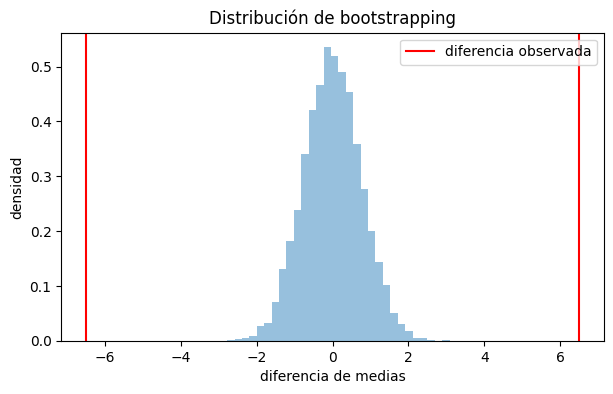

In [ ]:
# Distribución de bootstrapping
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=-dif_observada, color='red')

ax.set_title('Distribución de bootstrapping')
ax.set_xlabel('diferencia de medias')
ax.set_ylabel('densidad')
ax.legend();

In [ ]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_boot) > dif_observada))/len(dist_boot)
p_value_correc = (sum(np.abs(dist_boot) > dif_observada) + 1)/len(dist_boot + 1)
print(f"p-value sin corrección: {p_value}")
print(f"p-value con corrección: {p_value_correc}")

p-value sin corrección: 0.0
p-value con corrección: 0.00010001000100010001


In [ ]:
# Test para datos dependientes (p-value, intervalos de confianza)
# ==============================================================================

pg.ttest(
    x           = data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'On'].updrs_3,
    y           = data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'Off'].updrs_3,
    alternative = 'two-sided',
    paired      = False,
    correction  = False
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.926078,1278,two-sided,1.498845e-18,"[-7.93, -5.07]",0.509107,2.656e+15,1.0


**Conclusiones:**

1. Existen evidencias estadísticas para afirmar que hay diferencias en las medias de los grupos `N/A` y `On`. (*Bootstrapping*)

2. Existen evidencias estadísticas para afirmar que hay diferencias en las medias de los grupos `N/A` y `Off`. (*Bootstrapping*)

3. Existen evidencias estadísticas para afirmar que hay diferencias en las medias de los grupos `On` y `Off`. (*Bootstrapping* y *t-test*)

4. Agregar una categoría `N/A` a la variable `upd23b_clinical_state_on_medication` da información importante para las variables a predecir, en este caso, la variable `updrs_3`. Podemos asumir que las pacientes en el grupo `N/A` están en un estadío inicial de la enfermedad.

5. Hemos decidido no imputar los datos faltantes de la variable updrs_4 debido a que son muchos datos y esto podría afectar el rendimiento y la verosimilitud del modelo. Luego, la variable updrs_4 no será considerada en este estudio.



In [ ]:
data_clinical.groupby('upd23b_clinical_state_on_medication')['updrs_2'].describe()

,count,mean,std,min,25%,50%,75%,max
upd23b_clinical_state_on_medication,,,,,,,,
N/A,1308.0,3.775994,4.953909,0.0,0.0,2.0,6.0,28.0
Off,513.0,10.037037,5.894962,0.0,6.0,9.0,14.0,28.0
On,767.0,9.569752,6.336106,0.0,5.0,8.0,13.0,40.0


In [ ]:
data_clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588 entries, 0 to 2587
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2588 non-null   object 
 1   patient_id                           2588 non-null   int64  
 2   visit_month                          2588 non-null   int64  
 3   updrs_1                              2588 non-null   float64
 4   updrs_2                              2588 non-null   float64
 5   updrs_3                              2588 non-null   float64
 6   updrs_4                              1562 non-null   float64
 7   upd23b_clinical_state_on_medication  2588 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 161.9+ KB


In [ ]:
num_patient = len(data_clinical['patient_id'].unique())

print(f'En la tabla se tiene información de {num_patient} pacientes.')

En la tabla se tiene información de 248 pacientes.


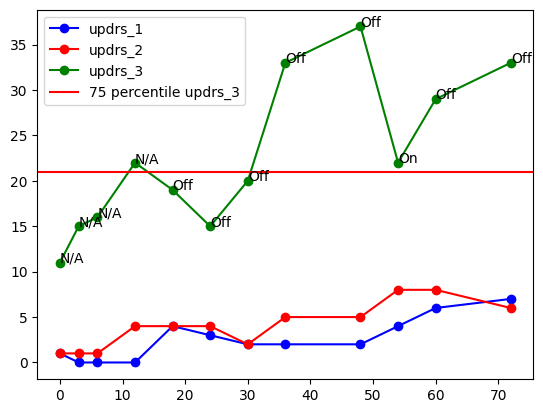

In [ ]:
np.random.seed(123)
index_na = np.random.choice(data_clinical[data_clinical.upd23b_clinical_state_on_medication == 'N/A'].index, 1)
id_na = data_clinical.loc[index_na,'patient_id'][int(index_na)]

df_patient = data_clinical[data_clinical['patient_id'] == id_na]
p = data_clinical[data_clinical['upd23b_clinical_state_on_medication'] == 'N/A']['updrs_3'].quantile(0.75)

fig, ax = plt.subplots(1, 1)

ax.plot(df_patient['visit_month'], df_patient['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(df_patient['visit_month'], df_patient['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(df_patient['visit_month'], df_patient['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.axhline(y = p, color = 'red', label = '75 percentile updrs_3')

for i in df_patient.index:
  ax.annotate(df_patient.loc[i,'upd23b_clinical_state_on_medication'], (df_patient.loc[i,'visit_month'], df_patient.loc[i,'updrs_3']))

ax.legend()
plt.show()

## Ahora vamos a observar el dataframe `data_proteins`. Las variables medidas en esta tabla son las siguientes:

* `visit_id`: ID de la visita del paciente.
* `visit_month`: El mes de la visita, relativo a la primera visita del paciente.
* `patient_id`: ID del paciente.
* `UniProt`: El código de identificación de [UniProt](https://www.uniprot.org/id-mapping) para la proteína asociada. A menudo hay varios péptidos por proteína.
* `NPX`: El índice Normalized Protein eXpression (NPX). Un valor alto de NPX equivale a una alta concentración de proteína.



In [ ]:
data_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [ ]:
data_proteins.shape

(232741, 5)

In [ ]:
data_proteins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232741 entries, 0 to 232740
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   visit_id     232741 non-null  object 
 1   visit_month  232741 non-null  int64  
 2   patient_id   232741 non-null  int64  
 3   UniProt      232741 non-null  object 
 4   NPX          232741 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.9+ MB


El dataframe tiene **232 741 observaciones** de **cinco variables**. De nuevo, cada vez que el paciente hace una visita se mide el indicador `NPX` por cada proteína encontrada.

**Nota:**

No hay valores perdidos en esta tabla. Todas las variables están en el tipo adecuado.

In [ ]:
num_patients = len(data_proteins['patient_id'].unique())
num_visits = len(data_proteins['visit_id'].unique())
print(f'La cantidad de pacientes para los cuales hay información en la tabla es {num_patients}')
print(f'La cantidad de visitas que realizan los pacientes es {num_visits}')

La cantidad de pacientes para los cuales hay información en la tabla es 248
La cantidad de visitas que realizan los pacientes es 1113


**Nota:**

Note que tenemos la misma cantidad de pacientes, pero menos visitas informadas.

In [ ]:
df_prot_na = data_proteins[data_proteins['patient_id'] == id_na]
num_visits = len(df_prot_na['visit_id'].unique())
print(f'Este paciente ha hecho {num_visits} visitas')

Este paciente ha hecho 5 visitas


In [ ]:
num_prot = len(df_prot_na['UniProt'].unique())
print(f'El número de proteínas medidas en este pacientes es {num_prot}')

El número de proteínas medidas en este pacientes es 224


In [ ]:
df_prot_na.groupby('visit_id')['UniProt'].count()

visit_id
56075_0     206
56075_12    212
56075_24    209
56075_48    215
56075_60    206
Name: UniProt, dtype: int64

In [ ]:
dist_num_prot = []
patients = data_proteins['patient_id'].unique()
for pat in patients:
  df_pat = data_proteins[data_proteins.patient_id == pat]
  num_min = df_pat.groupby('visit_id')['UniProt'].count().min()
  dist_num_prot.append(num_min)

df_num_min_prot = pd.DataFrame(data = {'Num_min_prot': dist_num_prot}, index = patients)

In [ ]:
pd.Series(dist_num_prot).describe()

count    248.000000
mean     202.379032
std       17.254040
min       37.000000
25%      198.000000
50%      207.000000
75%      212.000000
max      221.000000
dtype: float64

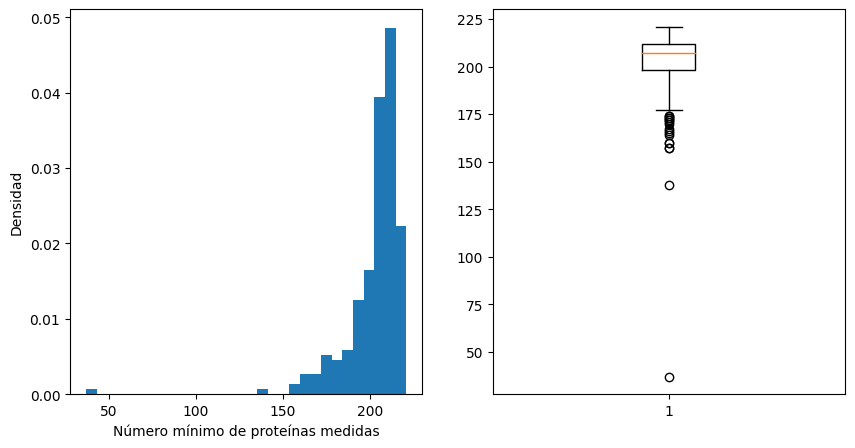

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].hist(dist_num_prot, bins = 30, density = True)
ax[0].set_xlabel('Número mínimo de proteínas medidas')
ax[0].set_ylabel('Densidad')
ax[1].boxplot(dist_num_prot)
plt.show()

In [ ]:
df_num_min_prot[df_num_min_prot['Num_min_prot'] == 37]

,Num_min_prot
25562,37


In [ ]:
data_proteins[data_proteins.patient_id == 25562].groupby('visit_id')['UniProt'].count()

visit_id
25562_0     194
25562_12    209
25562_24    207
25562_36     37
25562_48    205
25562_60    215
Name: UniProt, dtype: int64

In [ ]:
data_proteins = data_proteins[data_proteins['visit_id'] != '25562_36']

**Nota:**

Entonces, ¿qué vamos a hacer para unir la información de la tabla?

Vamos a elegir un número de proteínas dado, digamos $N$, y por cada paciente y cada visita vamos a agregar una cantidad de nuevas variables igual al número elegido. La primera variable es el valor `NPX` de la proteína que más se expresa en esa visita, la segunda es el valor `NPX` de la segunda, y así sucesivamente.

Esto significa que para predecir los valores `updrs_1`, `updrs_2`, `updrs_3` y `updrs_4` estamos utilizando los valores `NPX` de las $N$ proteínas que más se expresan en esa visita.

In [ ]:
def adding_features_prot(N):
  '''
  N: número de proteínas que se van a medir
  por paciente, por visita. Tiene que estar
  entre 10 y 37.
  '''
  visits_ids = data_proteins['visit_id'].unique()
  df_prep = data_clinical.query('visit_id in @visits_ids')
  new_features = np.zeros((df_prep.shape[0], N+1))

  for i, v in enumerate(df_prep['visit_id'].unique()):
    df_prot_N = data_proteins[data_proteins.visit_id == v].sort_values(by = 'NPX', ascending = False).head(N)['NPX'].values
    new_features[i,:N] = df_prot_N
    new_features[i,N] = data_proteins[data_proteins.visit_id == v].sort_values(by = 'NPX', ascending = False).reset_index(drop = True).loc[N:,'NPX'].mean()

  columns = []
  for i in range(1,N+1):
    columns.append('Prot_'+str(i))

  columns.append('Prot_mean')

  # df_proteins_N = pd.DataFrame(new_features, columns = columns)
  df_prep.loc[:,columns] = new_features

  return df_prep

In [ ]:
df_preparation = adding_features_prot(50)

In [ ]:
df_preparation.shape

(1057, 59)

In [ ]:
df_preparation.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,Prot_1,Prot_2,...,Prot_42,Prot_43,Prot_44,Prot_45,Prot_46,Prot_47,Prot_48,Prot_49,Prot_50,Prot_mean
0,55_0,55,0,10.0,6.0,15.0,NaN,N/A,390239000.0,43235500.0,...,1106490.0,1029290.0,982965.0,922153.0,862077.0,860978.0,842865.0,831886.0,732430.0,160878.682722
2,55_6,55,6,8.0,10.0,34.0,NaN,N/A,347572000.0,37999700.0,...,1045710.0,1023480.0,992375.0,952960.0,860236.0,801869.0,750870.0,746174.0,745064.0,153765.542917
4,55_12,55,12,10.0,10.0,41.0,0.0,On,383507000.0,38506400.0,...,1107460.0,1050600.0,1005020.0,969345.0,889307.0,884464.0,883059.0,815083.0,726036.0,161704.660523
8,55_36,55,36,17.0,18.0,51.0,0.0,On,449882000.0,45508900.0,...,1090610.0,1029240.0,938279.0,925399.0,910437.0,753832.0,708727.0,701968.0,692022.0,153288.695230
15,942_6,942,6,8.0,2.0,21.0,NaN,N/A,290111000.0,33323200.0,...,797355.0,780395.0,751635.0,714896.0,713430.0,704843.0,703395.0,676265.0,639154.0,126862.781928


### Vamos a tratar ahora el DataFrame `data_peptides`.

El dataframe `train_peptides` tienen **981 834 entradas** y **seis columnas**. Las proteínas son moléculas grandes compuestas por peptidos y en esta tabla se mide la abundacia de peptidos en una proteína que es relevante para la enfermedad del Parkinson.

Las variables medidas en la tabla son:

* `visit_id`: ID de la visita del paciente.
* `visit_month`: El mes de la visita, relativo a la primera visita del paciente.
* `patient_id`: ID del paciente.
* `UniProt`: El código de identificación de UniProt para la proteína asociada. A menudo hay varios péptidos por proteína.
* `Peptide`: La secuencia de aminoácidos incluidos en el péptido.
* `PeptideAbundance`: La frecuencia del aminoácido en la muestra.

In [ ]:
data_peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [ ]:
data_peptides.shape

(981834, 6)

In [ ]:
data_peptides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  object 
 5   PeptideAbundance  981834 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 44.9+ MB


In [ ]:
data_peptides = data_peptides[data_peptides['visit_id'] != '25562_36']

In [ ]:
num_patients = len(data_peptides['patient_id'].unique())
num_visits = len(data_peptides['visit_id'].unique())
print(f'Se tiene información de {num_patients} pacientes.')
print(f'El número de visitas hechas es {num_visits}.')

Se tiene información de 248 pacientes.
El número de visitas hechas es 1112.


In [ ]:
df_pep_patient = data_peptides[data_peptides['patient_id'] == id_na]
num_pep = len(df_pep_patient['Peptide'].unique())
num_prot = len(df_pep_patient['UniProt'].unique())
print(f'El número de peptides medidos en este paciente es {num_pep}.')
print(f'El número de proteínas medidas en este paciente es {num_prot}.')

El número de peptides medidos en este paciente es 961.
El número de proteínas medidas en este paciente es 224.


In [ ]:
df_pep_patient.groupby(['visit_id', 'UniProt'])['Peptide'].count().reset_index().drop(columns = 'Peptide').groupby('visit_id')['UniProt'].count()

visit_id
56075_0     206
56075_12    212
56075_24    209
56075_48    215
56075_60    206
Name: UniProt, dtype: int64

In [ ]:
dist_num_prot = []
patients = data_peptides['patient_id'].unique()
for pat in patients:
  df_pep_patient = data_peptides[data_peptides['patient_id'] == pat]
  num_min = df_pep_patient.groupby(['visit_id', 'UniProt'])['Peptide'].count().reset_index().drop(columns = 'Peptide').groupby('visit_id')['UniProt'].count().min()
  dist_num_prot.append(num_min)

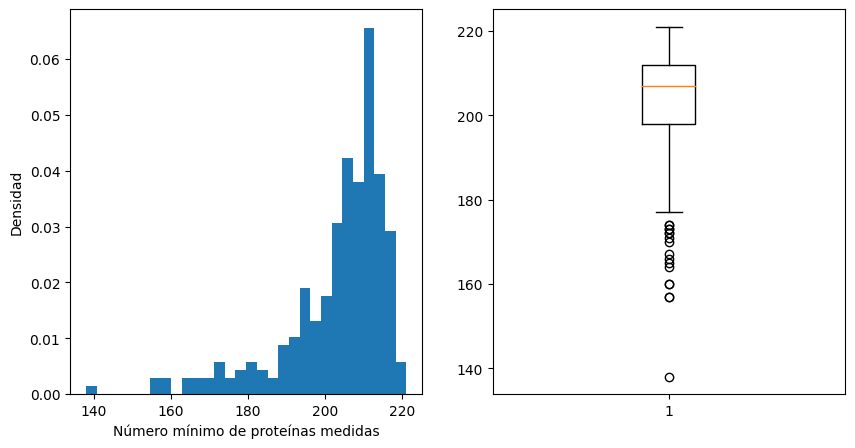

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].hist(dist_num_prot, bins = 30, density = True)
ax[0].set_xlabel('Número mínimo de proteínas medidas')
ax[0].set_ylabel('Densidad')
ax[1].boxplot(dist_num_prot)
plt.show()

**Nota:**

La distribución del número mínimo de proteínas medidas por paciente por visita es idéntica a la de la tabla `data_proteins`. Esto es un indicador de que con respecto a las proteínas medidas, ambas tienen la misma información.

In [ ]:
tem = data_peptides.groupby(['visit_id', 'UniProt'])['Peptide'].count().reset_index()
tem.head()

,visit_id,UniProt,Peptide
0,10053_0,O00391,1
1,10053_0,O00533,7
2,10053_0,O14773,1
3,10053_0,O14791,1
4,10053_0,O15240,2


In [ ]:
dis_pep_min_by_visit = []
visits = tem['visit_id'].unique()
for v in visits:
  num_min = tem[tem['visit_id'] == v]['Peptide'].min()
  dis_pep_min_by_visit.append(num_min)

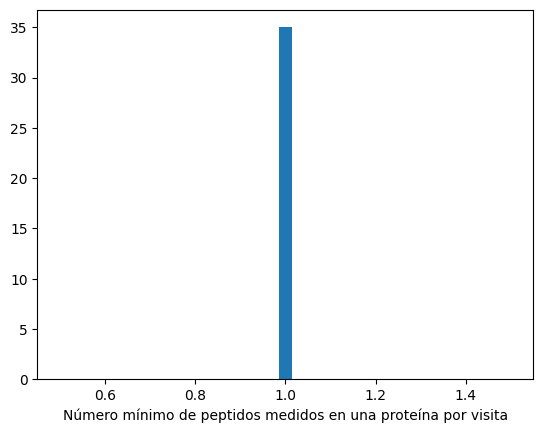

In [ ]:
plt.hist(dis_pep_min_by_visit, bins = 35, density = True)
plt.xlabel('Número mínimo de peptidos medidos en una proteína por visita')
plt.show()

**Nota:**

En este gráfico vemos que en todas las visitas, se tienen proteínas para las que solo se mide un peptido.

In [ ]:
visits = df_preparation['visit_id'].unique()
data_peptides = data_peptides.query('visit_id in @visits')

len(data_peptides['visit_id'].unique())

1057

In [ ]:
df_peptides_mean = data_peptides.groupby(['visit_id', 'UniProt'])['PeptideAbundance'].mean().reset_index()
df_peptides_mean.head()

,visit_id,UniProt,PeptideAbundance
0,10053_0,O00391,9104.270000
1,10053_0,O00533,57474.485714
2,10053_0,O14773,7150.570000
3,10053_0,O14791,2497.840000
4,10053_0,O15240,41501.450000


In [ ]:
def adding_features_pep(N):
  np_pep_by_prot = np.zeros(shape = (len(df_peptides_mean['visit_id'].unique()), N+1))
  visits =  df_peptides_mean['visit_id'].unique()
  for i, v in enumerate(visits):
    df_prot_N = data_proteins[data_proteins.visit_id == v].sort_values(by = 'NPX', ascending = False).head(N)['UniProt'].values
    np_pep_by_prot[i,:N] = df_peptides_mean.query('(UniProt in @df_prot_N) and (visit_id == @v)')['PeptideAbundance']
    np_pep_by_prot[i,N] = df_peptides_mean.query('UniProt not in @df_prot_N')['PeptideAbundance'].mean()

  columns = []
  for i in range(1,N+1):
    columns.append('PeptideAbundance_'+str(i))

  columns.append('PeptideAbundance_mean')

  df_preparation.loc[:,columns] = np_pep_by_prot

  return df_preparation

In [ ]:
df_preparation = adding_features_pep(50)

In [ ]:
df_preparation.shape

(1057, 110)

In [ ]:
df_preparation = df_preparation.reset_index(drop = True)
df_preparation.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,Prot_1,Prot_2,...,PeptideAbundance_42,PeptideAbundance_43,PeptideAbundance_44,PeptideAbundance_45,PeptideAbundance_46,PeptideAbundance_47,PeptideAbundance_48,PeptideAbundance_49,PeptideAbundance_50,PeptideAbundance_mean
0,55_0,55,0,10.0,6.0,15.0,NaN,N/A,390239000.0,43235500.0,...,91211.81250,223350.766667,8.502336e+06,150282.514286,601414.0,1.327970e+06,2.014220e+05,423833.00,109438.640000,79414.406566
1,55_6,55,6,8.0,10.0,34.0,NaN,N/A,347572000.0,37999700.0,...,707166.00000,165380.485714,6.820102e+06,123041.050000,521313.0,9.514260e+05,2.424638e+05,404816.00,103623.216667,59374.074012
2,55_12,55,12,10.0,10.0,41.0,0.0,On,383507000.0,38506400.0,...,103615.23750,234407.830000,7.664914e+06,120560.828571,568842.0,5.313140e+06,7.495008e+04,559521.00,111618.550000,62904.967788
3,55_36,55,36,17.0,18.0,51.0,0.0,On,449882000.0,45508900.0,...,470533.35625,103852.958333,1.067668e+05,231345.260000,6829787.2,1.166210e+05,3.898800e+06,213389.28,523281.000000,83921.207502
4,942_6,942,6,8.0,2.0,21.0,NaN,N/A,290111000.0,33323200.0,...,817398.00000,237122.590000,9.196576e+06,776245.000000,1936610.0,1.439816e+05,1.044400e+06,723347.00,123503.466667,57771.228661


# Preparación de las características y modelación

In [ ]:
X = df_preparation.drop(['patient_id', 'visit_id', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'], axis = 1)
y = df_preparation[['updrs_1', 'updrs_2', 'updrs_3']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()

In [ ]:
numeric_columns = list(X.select_dtypes(include = ['float64', 'int64']).columns)
scaler.fit(X_train[numeric_columns])
X_train[numeric_columns] = scaler.transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [ ]:
X_train.head()

,visit_month,upd23b_clinical_state_on_medication,Prot_1,Prot_2,Prot_3,Prot_4,Prot_5,Prot_6,Prot_7,Prot_8,...,PeptideAbundance_42,PeptideAbundance_43,PeptideAbundance_44,PeptideAbundance_45,PeptideAbundance_46,PeptideAbundance_47,PeptideAbundance_48,PeptideAbundance_49,PeptideAbundance_50,PeptideAbundance_mean
758,-1.154184,N/A,-1.295719,-1.089266,-1.194962,-0.802779,-0.645685,-0.583852,-0.236099,-0.512121,...,-0.216006,-0.320729,-0.755703,-0.635859,2.299823,-0.740138,2.272668,-0.592342,0.527731,-0.334308
442,0.403780,Off,0.343928,-1.132778,-0.691814,-0.164865,-1.224106,-0.661695,-1.955820,-1.744294,...,0.008330,-0.360534,-0.733167,2.420385,-0.756609,1.485660,-0.502488,-0.700084,1.684819,-0.405241
362,-1.154184,N/A,0.314192,0.321230,0.224479,1.380254,1.477570,-0.535760,-0.048025,0.223424,...,-0.235922,-0.315477,-0.763051,-0.460231,-0.767523,2.478046,-0.590829,4.914867,-0.581449,-0.331426
377,-1.154184,N/A,0.693547,0.039850,-0.243040,-0.418877,-0.267126,0.018148,0.423294,1.150675,...,-0.197714,-0.339322,0.725330,-0.669809,-0.540140,1.109095,-0.549708,-0.802986,0.526042,-0.843182
327,0.403780,N/A,-0.693385,-0.316744,0.786894,-0.577971,0.240281,-0.698737,0.065133,0.321436,...,-0.042423,-0.363335,-0.742809,1.262705,-0.775640,-0.413613,1.617926,-0.624533,0.524811,-0.791867


In [ ]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [ ]:
X_train.head()

,visit_month,Prot_1,Prot_2,Prot_3,Prot_4,Prot_5,Prot_6,Prot_7,Prot_8,Prot_9,...,PeptideAbundance_44,PeptideAbundance_45,PeptideAbundance_46,PeptideAbundance_47,PeptideAbundance_48,PeptideAbundance_49,PeptideAbundance_50,PeptideAbundance_mean,upd23b_clinical_state_on_medication_Off,upd23b_clinical_state_on_medication_On
758,-1.154184,-1.295719,-1.089266,-1.194962,-0.802779,-0.645685,-0.583852,-0.236099,-0.512121,-0.064255,...,-0.755703,-0.635859,2.299823,-0.740138,2.272668,-0.592342,0.527731,-0.334308,0,0
442,0.403780,0.343928,-1.132778,-0.691814,-0.164865,-1.224106,-0.661695,-1.955820,-1.744294,-1.260740,...,-0.733167,2.420385,-0.756609,1.485660,-0.502488,-0.700084,1.684819,-0.405241,1,0
362,-1.154184,0.314192,0.321230,0.224479,1.380254,1.477570,-0.535760,-0.048025,0.223424,0.771149,...,-0.763051,-0.460231,-0.767523,2.478046,-0.590829,4.914867,-0.581449,-0.331426,0,0
377,-1.154184,0.693547,0.039850,-0.243040,-0.418877,-0.267126,0.018148,0.423294,1.150675,-0.116363,...,0.725330,-0.669809,-0.540140,1.109095,-0.549708,-0.802986,0.526042,-0.843182,0,0
327,0.403780,-0.693385,-0.316744,0.786894,-0.577971,0.240281,-0.698737,0.065133,0.321436,0.240235,...,-0.742809,1.262705,-0.775640,-0.413613,1.617926,-0.624533,0.524811,-0.791867,0,0


In [ ]:
print(X_train.shape)
print(X_test.shape)

(845, 105)
(212, 105)


## Modelo red neuronal completamente conectada

En este caso vamos a usar una red neuronal completamente conectada para predecir las variables `updrs_1`, `updrs_2` y `updrs_3`. Creemos que en este caso, una red neuronal es el modelo adecuado debido a la cantidad de variables predictoras involucradas.

In [ ]:
units = [200, 300, 400, 500]
lr = [0.0001, 0.001, 0.01]
dr = [0.5, 0.6, 0.7]

In [ ]:
best_rmse_mean = 30
best_u = 0
best_lr = 0
best_dr = 0

for u in units:
  for l in lr:
    for d in dr:
      model = keras.Sequential()
      model.add(keras.layers.Dense(units = u, input_dim = X_train.shape[1], activation = 'relu'))
      model.add(keras.layers.Dropout(d))
      model.add(keras.layers.Dense(units = u/2, activation = 'relu'))
      model.add(keras.layers.Dropout(d))
      #model.add(keras.layers.Dense(units = 50, activation = 'relu'))
      # model.add(keras.layers.Dropout(0.5))
      model.add(keras.layers.Dense(units = 3, activation = 'relu'))

      opt = keras.optimizers.Adam(learning_rate=l)
      model.compile(optimizer=opt,
                    loss='mse',
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])
      model.fit(X_train, y_train, epochs=100, verbose=0,
          validation_data=(X_test, y_test))
      y_pred = model.predict(X_test)
      y_pred_updrs_1 = y_pred[:,0]
      rmse = mean_squared_error(y_pred_updrs_1, y_test['updrs_1'], squared=False)/y_test['updrs_1'].max()*100
      if rmse < best_rmse_mean:
        best_rmse_mean = rmse
        best_u = u
        best_lr = lr
        best_dr = dr

7/7 [==============================] - 0s 2ms/step


In [ ]:
best_rmse_mean

19.512547795214296